In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!pwd

/content/drive/MyDrive/DeepLearning/Transformer/notebook


In [3]:
%cd drive/MyDrive/DeepLearning/Transformer/notebook

/content/drive/MyDrive/DeepLearning/Transformer/notebook


In [4]:
import jieba
from sklearn.model_selection import train_test_split
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load_Data: data_sample

In [7]:
# 定义分词器
def tokenizer(text):
    return [tok for tok in jieba.cut(text)]


# 自定义数据集类
class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.tokenizer(self.data.iloc[idx, 1])
        trg = self.tokenizer(self.data.iloc[idx, 0])
        return {'src': src, 'trg': trg}


# 读取数据并划分为训练集和验证集
data = pd.read_csv('../data/data_sample.tsv', sep='\t', header=0)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 创建数据集实例
train_dataset = TextDataset(train_data, tokenizer)
val_dataset = TextDataset(val_data, tokenizer)


# 构建词汇表
def build_vocab(data, min_freq=2):
    counter = Counter()
    for item in data:
        counter.update(item['src'])
        # counter.update(item['trg'])
    # 过滤低频词，只保留频率大于等于min_freq的词
    filtered_words = [word for word, freq in counter.items() if freq >= min_freq]

    # 为词汇表创建连续的索引，从4开始编号，保留特殊标记
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    vocab.update({word: idx for idx, word in enumerate(filtered_words, start=4)})

    return vocab


# 创建词汇表
vocab = build_vocab(train_dataset, min_freq=2)

# 定义索引转换和特殊标记索引
PAD_IDX = vocab['<pad>']
UNK_IDX = vocab['<unk>']
SOS_IDX = vocab['<sos>']
EOS_IDX = vocab['<eos>']


# 批次处理函数
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for item in batch:
        src = [vocab.get(token, UNK_IDX) for token in item['src']]
        trg = [vocab.get(token, UNK_IDX) for token in item['trg']]
        src_batch.append([SOS_IDX] + src + [EOS_IDX])
        trg_batch.append([SOS_IDX] + trg + [EOS_IDX])

    src_batch = pad_sequence([torch.tensor(x) for x in src_batch], padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence([torch.tensor(x) for x in trg_batch], padding_value=PAD_IDX, batch_first=True)
    return src_batch, trg_batch


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

## Load_Data: LCSTS

In [10]:
# 定义分词器
def tokenizer(text):
    return [tok for tok in jieba.cut(text)]

# 自定义数据集类，加载src和trg文件
class TextDataset(Dataset):
    def __init__(self, src_file, trg_file, tokenizer, sample_ratio=0.1):
        with open(src_file, 'r', encoding='utf-8') as f_src, open(trg_file, 'r', encoding='utf-8') as f_trg:
            src_lines = f_src.readlines()
            trg_lines = f_trg.readlines()

        # 确保src和trg长度一致，并对数据进行采样
        assert len(src_lines) == len(trg_lines), "Source and Target files must have the same number of lines"
        sample_size = int(len(src_lines) * sample_ratio)
        self.data = [(src_lines[i].strip(), trg_lines[i].strip()) for i in range(sample_size)]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.tokenizer(self.data[idx][0])
        trg = self.tokenizer(self.data[idx][1])
        return {'src': src, 'trg': trg}

# 创建训练集和验证集，数据采样比例可以调整
train_dataset = TextDataset('../data/LCSTS/train.src.txt', '../data/LCSTS/train.tgt.txt', tokenizer, sample_ratio=0.005)
val_dataset = TextDataset('../data/LCSTS/test.src.txt', '../data/LCSTS/test.tgt.txt', tokenizer, sample_ratio=0.005)

# 构建词汇表
def build_vocab(data, min_freq=2):
    counter = Counter()
    for item in data:
        counter.update(item['src'])
        # counter.update(item['trg'])
    # 过滤低频词，只保留频率大于等于min_freq的词
    filtered_words = [word for word, freq in counter.items() if freq >= min_freq]
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    vocab.update({word: idx for idx, word in enumerate(filtered_words, start=4)})
    return vocab

# 创建词汇表
vocab = build_vocab(train_dataset, min_freq=2)

print(f"Vocab size: {len(vocab)}")

# 定义索引转换和特殊标记索引
PAD_IDX = vocab['<pad>']
UNK_IDX = vocab['<unk>']
SOS_IDX = vocab['<sos>']
EOS_IDX = vocab['<eos>']

# 批次处理函数
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for item in batch:
        src = [vocab.get(token, UNK_IDX) for token in item['src']]
        trg = [vocab.get(token, UNK_IDX) for token in item['trg']]
        src_batch.append([SOS_IDX] + src + [EOS_IDX])
        trg_batch.append([SOS_IDX] + trg + [EOS_IDX])

    # 将张量移动到指定device
    src_batch = pad_sequence([torch.tensor(x).to(device) for x in src_batch], padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence([torch.tensor(x).to(device) for x in trg_batch], padding_value=PAD_IDX, batch_first=True)
    return src_batch, trg_batch


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

Vocab size: 30060


## Model

In [7]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32, device=device))

    # input shape: [batch size, seq len, hid dim]
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy = [batch size, n heads, query len, key len]

        if mask is not None:
            mask = mask.to(torch.float32)
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)
        # attention = [batch size, n heads, query len, key len]

        # assert(key len == value len)
        x = torch.matmul(self.dropout(attention), V)
        # x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch size, query len, n heads, head dim]

        # Note: Recover the original shape of x
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch size, query len, hid dim]

        x = self.fc_o(x)
        # x = [batch size, query len, hid dim]

        return x, attention


class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))
        # x = [batch size, seq len, pf dim]

        x = self.fc_2(x)
        # x = [batch size, seq len, hid dim]

        return x


class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src = [batch size, src len, hid dim]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src = [batch size, src len, hid dim]

        # Feedforward
        _src = self.positionwise_feedforward(src)
        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src = [batch size, src len, hid dim]

        return src


class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)
            # src = [batch size, src len, hid dim]

        return src


class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch size, trg len, hid dim]

        # encoder attention
        # input: [query, key, value, mask]
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # attention = [batch size, n heads, trg len, src len]
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch size, trg len, hid dim]

        # Feedforward
        _trg = self.positionwise_feedforward(trg)
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg = [batch size, trg len, hid dim]

        return trg, attention


class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            # trg = [batch size, trg len, hid dim]
            # attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)
        # output = [batch size, trg len, output dim]

        return output, attention


class Transformer(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 pad_idx,
                 device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src = [batch size, src len]
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask = [batch size, 1, 1, src len]
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # trg = [batch size, trg len]
        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device, dtype=torch.bool))
        # trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask.to(dtype=torch.float32)

    def forward(self, src, trg):
        # src = [batch size, src len]
        # trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        # enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]
        return output, attention

## Test_GPU

In [9]:
import torch

# 示例数据
batch_size = 2
src_len, trg_len = 5, 5
hid_dim = 256
n_heads = 8
pf_dim = 512
dropout = 0.1

# 输入
src = torch.randint(0, 100, (batch_size, src_len)).to(device)
trg = torch.randint(0, 100, (batch_size, trg_len)).to(device)
src_mask = torch.ones((batch_size, 1, 1, src_len), dtype=torch.bool).to(device)
trg_mask = torch.ones((batch_size, 1, trg_len, trg_len), dtype=torch.bool).to(device)

# 初始化模型组件
try:
    encoder_layer = EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device).to(device)
    print("Encoder Layer initialized on GPU.")
    enc_src = encoder_layer(src, src_mask)
    print("Encoder Layer forward pass succeeded on GPU.")
except Exception as e:
    print(f"Error in Encoder Layer: {e}")

try:
    decoder_layer = DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device).to(device)
    print("Decoder Layer initialized on GPU.")
    trg_output, attention = decoder_layer(trg, enc_src, trg_mask, src_mask)
    print("Decoder Layer forward pass succeeded on GPU.")
except Exception as e:
    print(f"Error in Decoder Layer: {e}")

try:
    encoder = Encoder(input_dim=100, hid_dim=hid_dim, n_layers=2, n_heads=n_heads, pf_dim=pf_dim, dropout=dropout, device=device).to(device)
    print("Encoder initialized on GPU.")
    enc_src = encoder(src, src_mask)
    print("Encoder forward pass succeeded on GPU.")
except Exception as e:
    print(f"Error in Encoder: {e}")

try:
    decoder = Decoder(output_dim=100, hid_dim=hid_dim, n_layers=2, n_heads=n_heads, pf_dim=pf_dim, dropout=dropout, device=device).to(device)
    print("Decoder initialized on GPU.")
    output, attention = decoder(trg, enc_src, trg_mask, src_mask)
    print("Decoder forward pass succeeded on GPU.")
except Exception as e:
    print(f"Error in Decoder: {e}")

try:
    transformer = Transformer(encoder, decoder, pad_idx=0, device=device).to(device)
    print("Transformer model initialized on GPU.")
    output, attention = transformer(src, trg)
    print("Transformer forward pass succeeded on GPU.")
except Exception as e:
    print(f"Error in Transformer: {e}")


Encoder Layer initialized on GPU.
Error in Encoder Layer: mat1 and mat2 must have the same dtype, but got Long and Float
Decoder Layer initialized on GPU.
Error in Decoder Layer: name 'enc_src' is not defined
Encoder initialized on GPU.
Encoder forward pass succeeded on GPU.
Decoder initialized on GPU.
Decoder forward pass succeeded on GPU.
Transformer model initialized on GPU.
Transformer forward pass succeeded on GPU.


[Eval Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 24.05it/s, loss=7.65]


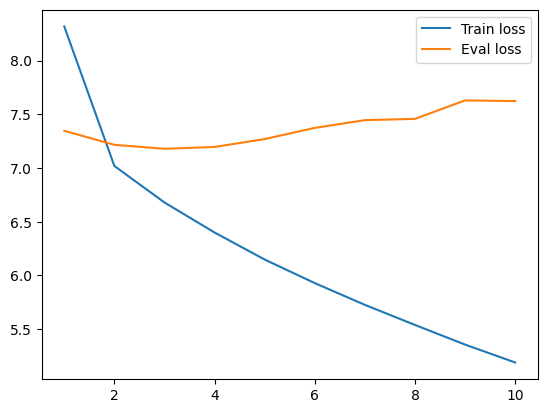

In [11]:
# Model hyperparameters
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
HID_DIM = 512
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2048
DEC_PF_DIM = 2048
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
N_EPOCHS = 10
CLIP = 1

# Instantiate encoder, decoder, and transformer model
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)
model = Transformer(enc, dec, PAD_IDX, device).to(device)


# Xavier 均匀分布初始化权重 weights
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


model.apply(initialize_weights)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Track loss values for training and evaluation
loss_vals = []
loss_vals_eval = []

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = []

    # 添加进度条显示
    pbar = tqdm(train_loader)
    pbar.set_description(f"[Train Epoch {epoch}]")

    for src, trg in pbar:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        # trg[:, :-1] 去掉了目标序列中的最后一个位置，以确保模型只能看到部分的 trg 序列，并生成下一个单词。
        # trg[:, 1:] 去掉了目标序列中的第一个位置，让模型逐步学习如何从已生成的部分生成下一个单词。
        # trg = [<sos>, "I", "love", "NLP", <eos>]
        # trg[:, :-1] = [<sos>, "I", "love", "NLP"]
        # trg[:, 1:]  = ["I", "love", "NLP", <eos>]
        output, _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # output = [batch_size * (trg_len - 1), output_dim]
        trg = trg[:, 1:].contiguous().view(-1)
        # trg = [batch_size * (trg_len - 1)]

        # 模型中没有显式使用 softmax，但在损失计算时通过 CrossEntropyLoss 完成了 softmax 转换。
        loss = criterion(output, trg)
        loss.backward()

        # 执行梯度裁剪，限制每个参数梯度的最大范数为 CLIP，防止梯度爆炸。
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        epoch_loss.append(loss.item())
        pbar.set_postfix(loss=loss.item())

    loss_vals.append(np.mean(epoch_loss))

    # Evaluate the model
    model.eval()
    epoch_loss_eval = []
    with torch.no_grad():
        pbar = tqdm(val_loader)
        pbar.set_description(f"[Eval Epoch {epoch}")

        for src, trg in pbar:
            src, trg = src.to(device), trg.to(device)
            output, _ = model(src, trg[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss_eval.append(loss.item())
            pbar.set_postfix(loss=loss.item())

    loss_vals_eval.append(np.mean(epoch_loss_eval))

# Save model
# torch.save(model.state_dict(), 'model.pt')

# Plot the training and evaluation losses
l1, = plt.plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), loss_vals)
l2, = plt.plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), loss_vals_eval)
plt.legend(handles=[l1, l2], labels=['Train loss', 'Eval loss'], loc='best')
plt.show()

In [32]:
torch.cuda.empty_cache()

In [12]:
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
HID_DIM = 512
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2048
DEC_PF_DIM = 2048
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# 初始化编码器、解码器和Transformer模型
# enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
# dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)
# model = Transformer(enc, dec, PAD_IDX, device).to(device)

# 加载预训练模型
# model.load_state_dict(torch.load('model.pt'))
model.eval()

# 输入句子并分词
sent = '中国铁路总公司消息，自2015年1月5日起，自行车不能进站乘车了。骑友大呼难以接受。这部分希望下车就能踏上骑游旅程的旅客，只能先办理托运业务，可咨询12306客服电话，就近提前办理。运费每公斤价格根据运输里程不同而不同。'
tokens = [tok for tok in jieba.cut(sent)]
tokens = ['<sos>'] + tokens + ['<eos>']

# 将分词转换为词汇表索引
src_indexes = [vocab.get(token, UNK_IDX) for token in tokens]
src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
src_mask = model.make_src_mask(src_tensor)

# 编码输入句子
with torch.no_grad():
    enc_src = model.encoder(src_tensor, src_mask)

# 初始化目标序列的索引列表
trg_indexes = [SOS_IDX]

# 逐步生成翻译结果
for i in range(50):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
    trg_mask = model.make_trg_mask(trg_tensor)

    with torch.no_grad():
        output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

    pred_token = output.argmax(2)[:,-1].item()
    trg_indexes.append(pred_token)

    if pred_token == EOS_IDX:
        break

# 将目标序列的索引转换回词汇表的词汇
trg_tokens = [list(vocab.keys())[list(vocab.values()).index(i)] for i in trg_indexes]

# 输出结果（去除<sos>标记）
print(trg_tokens[1:])

['海南', '：', '月', '<unk>', '元', '数据', '可', '元', '？', '<eos>']
